In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
import sklearn.metrics as skmetrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
zillow_df = pd.read_csv('zillow-carlifornia.csv')

<h3>Initial Exploration </h3>

In [3]:
zillow_df.head()

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
0,2008-02-29,470000.0,5.29,6.3
1,2008-03-31,441000.0,5.44,6.2
2,2008-04-30,460000.0,5.42,6.4
3,2008-05-31,429000.0,5.47,6.3
4,2008-06-30,437500.0,5.60,6.2


In [4]:
zillow_df.shape

(107, 4)

In [5]:
zillow_df.describe()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
count,95.000000,107.000000,107.000000
mean,399105.263158,4.186542,6.823364
std,45971.423521,0.636049,1.183979
min,335000.000000,3.290000,4.700000
25%,360125.000000,3.780000,6.100000
50%,375000.000000,4.060000,7.000000
75%,440000.000000,4.430000,7.650000
max,489000.000000,6.030000,9.100000


In [6]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 4 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Date                                 107 non-null    object 
 1   MedianSoldPrice_AllHomes.California  95 non-null     float64
 2   MedianMortageRate                    107 non-null    float64
 3   UnemploymentRate                     107 non-null    float64
dtypes: float64(3), object(1)
memory usage: 3.5+ KB


In [7]:
zillow_df.columns

Index(['Date', 'MedianSoldPrice_AllHomes.California', 'MedianMortageRate',
       'UnemploymentRate'],
      dtype='object')

In [8]:
median_price_df=zillow_df[['Date', 'MedianSoldPrice_AllHomes.California']].copy()

In [9]:
median_price_df.set_index('Date',inplace=True)
median_price_df.head()

,MedianSoldPrice_AllHomes.California
Date,
2008-02-29,470000.0
2008-03-31,441000.0
2008-04-30,460000.0
2008-05-31,429000.0
2008-06-30,437500.0


In [10]:
median_price_df.isnull()

,MedianSoldPrice_AllHomes.California
Date,
2008-02-29,False
2008-03-31,False
2008-04-30,False
2008-05-31,False
2008-06-30,False
...,...
2016-08-31,True
2016-09-30,True
2016-10-31,True


In [11]:
median_price_df=median_price_df.dropna()

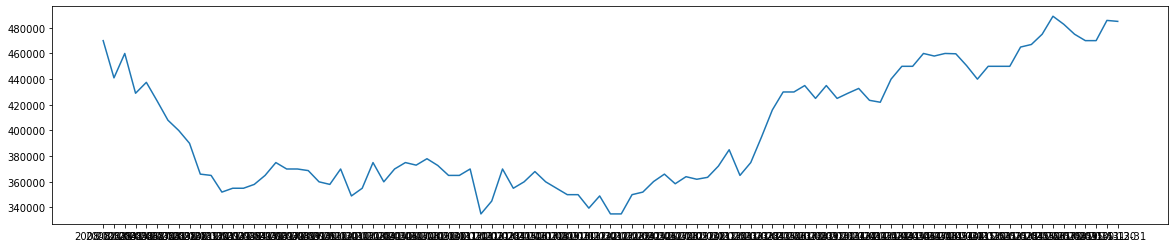

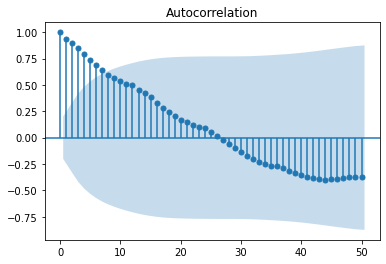

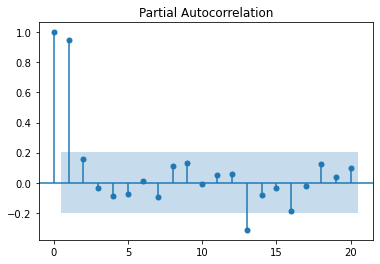

In [16]:
fig,ax=plt.subplots(figsize=(20,4))
ax.plot(median_price_df)
plt.show()
plot_acf(median_price_df,lags=50) 
plt.show()
plot_pacf(median_price_df,lags=20) 
plt.show()